In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

from ast import literal_eval
from datetime import datetime
import os, sys, json, re, string

In [ ]:
path = "/content/drive/MyDrive/Graduate/Semester 1 (Fall 2024)/INFO-H423 Data Mining/Project/SNCB_IncidentClassifier"

In [ ]:
df = pd.read_csv(f'{path}/data/time_sorted_table.csv', delimiter=';', index_col=0)
df.head()

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
0,4432881,"[609, 609, 609, 609, 609, 609, 609, 609, 609, ...","[2744, 4004, 2852, 4110, 2854, 4396, 1132, 414...","[-5510, -5510, -5507, -5507, -5506, -5506, -55...",50.876601,4.718143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",4
1,4432943,"[526, 526, 1094, 526, 526, 526, 1094, 1094, 10...","[2744, 4148, 4016, 4394, 1566, 1570, 4394, 156...","[-8573, -8573, -8572, -8032, -8032, -8032, -80...",51.037435,4.431218,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13
2,4432955,"[592, 592, 592, 643, 643, 643, 616, 616, 616, ...","[4394, 1566, 1570, 4394, 1566, 1570, 2674, 156...","[-12291, -12291, -12291, -12291, -12291, -1229...",50.864083,4.162115,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",14
3,4433021,"[663, 576, 663, 663, 663, 663, 576, 663, 663, ...","[4066, 4066, 3636, 3658, 4078, 4066, 4066, 363...","[-14353, -14351, -14340, -14340, -14330, -1420...",51.183220,4.276025,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",2
4,4433129,"[647, 647, 647, 647, 647, 647, 634, 634, 634, ...","[4002, 4032, 4028, 2852, 4026, 4110, 4002, 403...","[-227, -227, -226, -225, -225, -225, -224, -22...",50.818727,3.253601,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14


In [ ]:
test_size = 0.33
X = df.drop(columns=['incident_type'], axis=1)
y = df['incident_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((677, 9), (334, 9), (677,), (334,))

In [ ]:
y_stats = pd.DataFrame(y.value_counts())
y_stats = y_stats.reset_index()
y_stats.columns = ['incident_type', 'count_y']
y_stats['percentage_y'] = y_stats.apply(lambda x: x['count_y'] / len(y), axis=1)

y_stats['count_y_train'] = y_stats.apply(lambda x: y_train.value_counts()[x['incident_type']], axis=1)
y_stats['percentage_y_train'] = y_stats.apply(lambda x: x['count_y_train'] / len(y_train), axis=1)

y_stats['count_y_test'] = y_stats.apply(lambda x: y_test.value_counts()[x['incident_type']], axis=1)
y_stats['percentage_y_test'] = y_stats.apply(lambda x: x['count_y_test'] / len(y_test), axis=1)

y_stats

,incident_type,count_y,percentage_y,count_y_train,percentage_y_train,count_y_test,percentage_y_test
0,13,318,0.314540,213,0.314623,105,0.314371
1,99,175,0.173096,117,0.172821,58,0.173653
2,14,149,0.147379,100,0.147710,49,0.146707
3,2,119,0.117705,80,0.118168,39,0.116766
4,9,117,0.115727,78,0.115214,39,0.116766
5,4,78,0.077151,52,0.076809,26,0.077844
6,11,26,0.025717,17,0.025111,9,0.026946
7,17,10,0.009891,7,0.010340,3,0.008982
8,6,6,0.005935,4,0.005908,2,0.005988
9,3,5,0.004946,3,0.004431,2,0.005988


In [ ]:
df_train = X_train
df_train['incident_type'] = y_train

df_test = X_test
df_test['incident_type'] = y_test

In [ ]:
w = 150
l = 10

In [ ]:
def gen_seq(events, seconds, w, l):
    sequences = []
    anomaly_counts = []
    stop = False
    idx = 0
    cover = 0
    while not stop:
        if idx <= len(events) - w:
            seq = events[idx:idx+w]
            secs = seconds[idx:idx+w]
            anomaly_count = sum([1 for sec in secs if sec >= 0])
            if seq not in sequences:
                sequences.append(seq)
                anomaly_counts.append(anomaly_count)
                cover = idx + w - 1
            idx += l
        else:
            stop = True
    if cover < len(events) - 1 and len(events) >= w:
        seq = events[-w:]
        secs = seconds[-w:]
        sequences.append(seq)
        anomaly_counts.append(sum([1 for sec in secs if sec >= 0]))
    return sequences, anomaly_counts

In [ ]:
def generate_seqs(df, w, l):
    cols_to_transform = ['vehicles_sequence', 'events_sequence', 'seconds_to_incident_sequence',
                    'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence']
    for col in cols_to_transform:
        df[col] = df[col].apply(literal_eval)
    df_s = df[['incident_id', 'events_sequence', 'seconds_to_incident_sequence']]
    df_s['events_count'] = df_s.apply(lambda x: len(x.events_sequence), axis=1)
    all_seqs = []
    all_counts = []
    all_ids = []
    all_nums = []
    skip = 0
    for _, row in df_s.iterrows():
        if row['events_count'] >= w:
            seqs, counts = gen_seq(row.events_sequence, row.seconds_to_incident_sequence, w, l)
            all_seqs.append(seqs)
            all_counts.append(counts)
            all_ids.append([row.incident_id] * len(counts))
            all_nums.append(list(range(len(counts))))
        else:
            skip += 1

    col_names = [f't0{i}' if i < 10 else f't{i}' for i in range(w)]
    all_seqs_flat = [j for sub in all_seqs for j in sub]
    all_counts_flat = [j for sub in all_counts for j in sub]
    all_ids_flat = [j for sub in all_ids for j in sub]
    all_nums_flat = [j for sub in all_nums for j in sub]
    df_seq = pd.DataFrame(np.array(all_seqs_flat), columns=col_names)
    df_seq['anom_count'] = all_counts_flat
    df_seq['incident_id'] = all_ids_flat
    df_seq['num'] = all_nums_flat

    return df_seq

In [ ]:
df_train_seq = generate_seqs(df_train, w, l)
df_test_seq = generate_seqs(df_test, w, l)

df_train_seq.shape, df_test_seq.shape

<ipython-input-9-2a61447ee465>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['events_count'] = df_s.apply(lambda x: len(x.events_sequence), axis=1)
<ipython-input-9-2a61447ee465>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['events_count'] = df_s.apply(lambda x: len(x.events_sequence), axis=1)


((28472, 153), (14121, 153))

In [ ]:
df_train.to_csv(f'{path}/models/anomaly_detection/data/AD_train_data.csv')
df_test.to_csv(f'{path}/models/anomaly_detection/data/AD_test_data.csv')

In [ ]:
def classify(row, w):
    if row.anom_count == 0:
        return 'normal'
    if row.anom_count == w:
        return 'anomalous'
    if row.anom_count > 0 and row.anom_count < w:
        return 'ambiguous'

df_train_seq['class'] = df_train_seq.apply(lambda x: classify(x, w), axis=1)
df_train_norm = df_train_seq[df_train_seq['class'] == 'normal']
df_train_anom = df_train_seq[df_train_seq['class'] == 'anomalous']
df_train_ambig = df_train_seq[df_train_seq['class'] == 'ambiguous']

df_train_seq.shape, df_train_norm.shape, df_train_anom.shape, df_train_ambig.shape

((28472, 154), (19850, 154), (1589, 154), (7033, 154))

In [ ]:
df_train_seq.head()

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t144,t145,t146,t147,t148,t149,anom_count,incident_id,num,class
0,4124,4158,4162,4160,4068,2686,3636,3658,4124,2956,...,982,2938,4394,982,3636,3658,5,4444185,0,ambiguous
1,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,...,2682,2956,2956,2956,2956,2956,15,4444185,1,ambiguous
2,2956,2956,4166,4066,3636,3658,4124,2956,2956,2956,...,2956,2956,2956,2956,2956,2956,25,4444185,2,ambiguous
3,2956,2956,2956,2956,2956,2956,2956,2956,2956,2956,...,2956,2956,2956,2956,2956,2956,35,4444185,3,ambiguous
4,4068,4124,3982,4168,4142,2584,4140,4148,2956,4140,...,2956,2956,2956,2956,2956,2956,45,4444185,4,ambiguous


In [ ]:
col_names = [f't0{i}' if i < 10 else f't{i}' for i in range(w)]
corpus = []
for _, row in df_train_seq.iterrows():
    corpus.append(row[col_names].to_list())

corpus_norm = []
for _, row in df_train_norm.iterrows():
    corpus_norm.append(row[col_names].to_list())

corpus_anom = []
for _, row in df_train_anom.iterrows():
    corpus_anom.append(row[col_names].to_list())

corpus_ambig = []
for _, row in df_train_ambig.iterrows():
    corpus_ambig.append(row[col_names].to_list())

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x,
                             preprocessor=lambda x: x,
                             lowercase=False)
encoded_seqs = vectorizer.fit_transform(corpus)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
encoded_norm = vectorizer.transform(corpus_norm).toarray()
encoded_anom = vectorizer.transform(corpus_anom).toarray()
encoded_ambig = vectorizer.transform(corpus_ambig).toarray()

encoded_norm.shape, encoded_anom.shape, encoded_ambig.shape

((19850, 839), (1589, 839), (7033, 839))

In [ ]:
def create_model_0(input_dim):
    seq_len = input_dim
    embedding_dim = 1
    model = models.Sequential()
    # model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(layers.LSTM(100, activation='relu',
                          input_shape=(seq_len, embedding_dim),
                          kernel_initializer='glorot_uniform'))
    model.add(layers.RepeatVector(seq_len))
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(embedding_dim)))
    optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def create_model_tfidf(input_dim):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(input_dim, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
model = create_model_tfidf(encoded_norm.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
epochs = 10
hist = model.fit(encoded_norm, encoded_norm, epochs=epochs)

Epoch 1/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 4.5056e-04
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8862e-05
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8391e-05
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2900e-05
Epoch 5/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5173e-05
Epoch 6/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2885e-05
Epoch 7/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8124e-05
Epoch 8/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7137e-05
Epoch 9/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5842e-05
Epoch 10/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5555e-05


In [ ]:
y_norm = model.predict(encoded_norm)
y_anom = model.predict(encoded_anom)
y_ambig = model.predict(encoded_ambig)

y_norm.shape, y_anom.shape, y_ambig.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


((19850, 839), (1589, 839), (7033, 839))

In [ ]:
def mse(A, B):
    return (np.square(A - B)).mean()

In [ ]:
norm_errs = []
for i in range(len(y_norm)):
    norm_errs.append(mse(y_norm[i], encoded_norm[i]))

anom_errs = []
for i in range(len(y_anom)):
    anom_errs.append(mse(y_anom[i], encoded_anom[i]))

ambig_errs = []
for i in range(len(y_ambig)):
    ambig_errs.append(mse(y_ambig[i], encoded_ambig[i]))

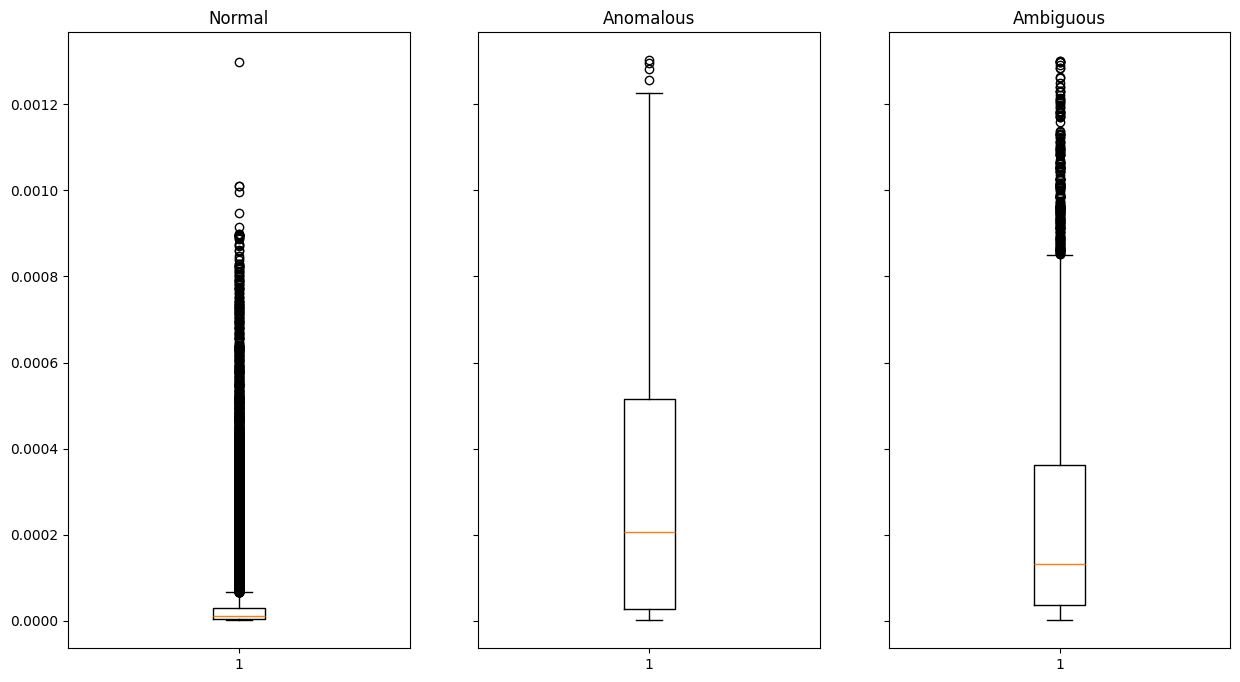

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 8))

axes[0].boxplot(np.array(norm_errs))
axes[1].boxplot(np.array(anom_errs))
axes[2].boxplot(np.array(ambig_errs))

axes[0].set_title('Normal')
axes[1].set_title('Anomalous')
axes[2].set_title('Ambiguous')

plt.show()

# Evaluate on train set

In [ ]:
df_train_norm['mse'] = norm_errs
df_train_anom['mse'] = anom_errs
df_train_ambig['mse'] = ambig_errs

df_train_mse = pd.concat([df_train_norm, df_train_anom, df_train_ambig])
df_train_mse = df_train_mse.sort_values(by=['incident_id', 'num'])

<ipython-input-24-fc46c0431a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_norm['mse'] = norm_errs
<ipython-input-24-fc46c0431a69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_anom['mse'] = anom_errs
<ipython-input-24-fc46c0431a69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [ ]:
def discounted_cumulative_gain(ranks):
    dcg = 0.0
    for rank in ranks:
        dcg = dcg + 1.0 / np.log2(rank + 1)
    return dcg

def normalized_discounted_cumulative_gain(ranks):
    num_gt = len(ranks)
    dcg = discounted_cumulative_gain(ranks)
    maxdcg = 0.0
    for i in range(1, num_gt + 1):
        maxdcg = maxdcg + 1.0 / np.log2(i + 1)
    return dcg / maxdcg

def eval_incident(df_mse, incident_id):
    incident_df = df_mse[df_mse['incident_id'] == incident_id]
    ranked_df = incident_df.sort_values(by='mse', ascending=False)
    a_list = incident_df[incident_df['class'] != 'normal']['num'].to_list()
    violators = ranked_df['num'].to_list()
    true_pos = list(set(violators) & set(a_list))
    true_pos_positions = [i+1 for i, x in enumerate(violators) if x in true_pos]
    ndcg = normalized_discounted_cumulative_gain(true_pos_positions)
    return ndcg

In [ ]:
NDCGs = dict()
skip_seqs = 0
for incident_id in df_train_mse['incident_id'].unique():
    incident_df = df_train_mse[df_train_mse['incident_id'] == incident_id]
    non_norm_count = sum([1 for x in incident_df["class"].to_list() if x != "normal"])
    norm_count = sum([1 for x in incident_df["class"].to_list() if x == "normal"])
    if non_norm_count != 0 and norm_count != 0:
        NDCGs[incident_id] = eval_incident(df_train_mse, incident_id)
    elif non_norm_count == 0:
        skip_seqs += 1
        print(f'{incident_id}: non-norm count = 0')
    elif norm_count == 0:
        skip_seqs += 1
        print(f'{incident_id}: norm count = 0')

print(f'Skipped {skip_seqs} sequences')

4433129: norm count = 0
4434099: norm count = 0
4434357: norm count = 0
4434367: norm count = 0
4434489: norm count = 0
4434591: norm count = 0
4434961: norm count = 0
4435025: norm count = 0
4435647: norm count = 0
4436345: norm count = 0
4436677: norm count = 0
4436761: norm count = 0
4438063: norm count = 0
4439225: norm count = 0
4439855: norm count = 0
4440081: non-norm count = 0
4440569: norm count = 0
4441353: norm count = 0
4441913: norm count = 0
4443277: norm count = 0
4443491: norm count = 0
4444185: norm count = 0
4444395: norm count = 0
4445785: norm count = 0
4445927: norm count = 0
4446193: norm count = 0
4446547: norm count = 0
4447733: norm count = 0
4448465: norm count = 0
4450243: norm count = 0
4450417: non-norm count = 0
4450705: norm count = 0
4451181: norm count = 0
4452763: norm count = 0
4453209: norm count = 0
4453289: norm count = 0
4453817: norm count = 0
4455573: norm count = 0
4455929: norm count = 0
4456519: norm count = 0
4457079: norm count = 0
4457311:

In [ ]:
len(list(NDCGs.keys()))

538

In [ ]:
ndcg_mean = np.mean(list(NDCGs.values()))
ndcg_median = np.median(list(NDCGs.values()))
print('Normalized discounted cumulative gain (NDCG) score:')
print(f'\tMean: {ndcg_mean}')
print(f'\tMedian: {ndcg_median}')

Normalized discounted cumulative gain (NDCG) score:
	Mean: 0.8814435022343229
	Median: 0.9840386048608851


# Evaluate on test set

In [ ]:
df_test_seq.head(2)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t143,t144,t145,t146,t147,t148,t149,anom_count,incident_id,num
0,4004,2852,4110,2854,4026,4092,4094,4394,492,502,...,2956,4066,3636,3658,4124,2956,2956,0,4608091,0
1,2708,2744,4026,4140,4148,4152,4168,4156,2740,490,...,2956,2956,2956,2956,2956,4066,3636,0,4608091,1


In [ ]:
df_test_seq['class'] = df_test_seq.apply(lambda x: classify(x, w), axis=1)
df_test_norm = df_test_seq[df_test_seq['class'] == 'normal']
df_test_anom = df_test_seq[df_test_seq['class'] == 'anomalous']
df_test_ambig = df_test_seq[df_test_seq['class'] == 'ambiguous']

df_test_seq.shape, df_test_norm.shape, df_test_anom.shape, df_test_ambig.shape

((14121, 154), (9679, 154), (959, 154), (3483, 154))

In [ ]:
corpus_norm_test = []
for _, row in df_test_norm.iterrows():
    corpus_norm_test.append(row[col_names].to_list())

corpus_anom_test = []
for _, row in df_test_anom.iterrows():
    corpus_anom_test.append(row[col_names].to_list())

corpus_ambig_test = []
for _, row in df_test_ambig.iterrows():
    corpus_ambig_test.append(row[col_names].to_list())

In [ ]:
encoded_norm_test = vectorizer.transform(corpus_norm_test).toarray()
encoded_anom_test = vectorizer.transform(corpus_anom_test).toarray()
encoded_ambig_test = vectorizer.transform(corpus_ambig_test).toarray()

encoded_norm_test.shape, encoded_anom_test.shape, encoded_ambig_test.shape

((9679, 839), (959, 839), (3483, 839))

In [ ]:
y_norm_test = model.predict(encoded_norm_test)
y_anom_test = model.predict(encoded_anom_test)
y_ambig_test = model.predict(encoded_ambig_test)

y_norm_test.shape, y_anom_test.shape, y_ambig_test.shape

303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


((9679, 839), (959, 839), (3483, 839))

In [ ]:
norm_errs_test = []
for i in range(len(y_norm_test)):
    norm_errs_test.append(mse(y_norm_test[i], encoded_norm_test[i]))

anom_errs_test = []
for i in range(len(y_anom_test)):
    anom_errs_test.append(mse(y_anom_test[i], encoded_anom_test[i]))

ambig_errs_test = []
for i in range(len(y_ambig_test)):
    ambig_errs_test.append(mse(y_ambig_test[i], encoded_ambig_test[i]))

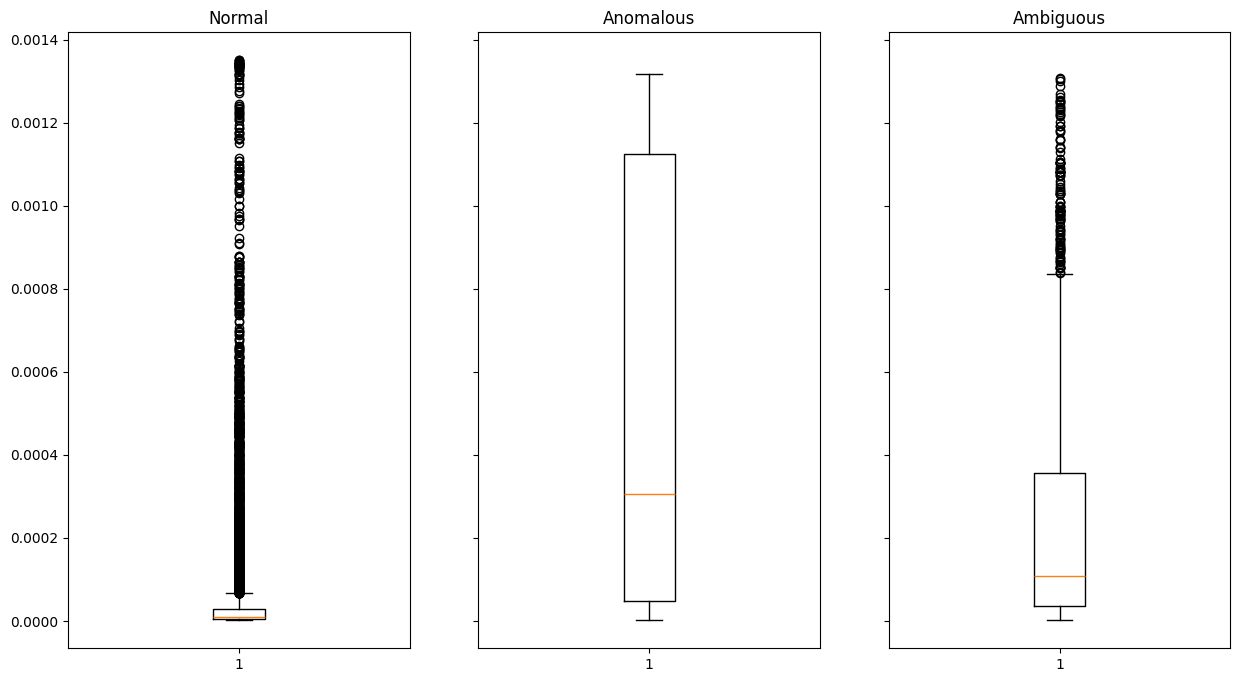

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 8))

axes[0].boxplot(np.array(norm_errs_test))
axes[1].boxplot(np.array(anom_errs_test))
axes[2].boxplot(np.array(ambig_errs_test))

axes[0].set_title('Normal')
axes[1].set_title('Anomalous')
axes[2].set_title('Ambiguous')

plt.show()

In [ ]:
df_test_norm['mse'] = norm_errs_test
df_test_anom['mse'] = anom_errs_test
df_test_ambig['mse'] = ambig_errs_test

df_test_mse = pd.concat([df_test_norm, df_test_anom, df_test_ambig])
df_test_mse = df_test_mse.sort_values(by=['incident_id', 'num'])

<ipython-input-36-43cd2ca1cdef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_norm['mse'] = norm_errs_test
<ipython-input-36-43cd2ca1cdef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_anom['mse'] = anom_errs_test
<ipython-input-36-43cd2ca1cdef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [ ]:
NDCGs_test = dict()
skip_seqs_test = 0
for incident_id in df_test_mse['incident_id'].unique():
    incident_df = df_test_mse[df_test_mse['incident_id'] == incident_id]
    non_norm_count = sum([1 for x in incident_df["class"].to_list() if x != "normal"])
    norm_count = sum([1 for x in incident_df["class"].to_list() if x == "normal"])
    if non_norm_count != 0 and norm_count != 0:
        NDCGs_test[incident_id] = eval_incident(df_test_mse, incident_id)
    elif non_norm_count == 0:
        skip_seqs += 1
        print(f'{incident_id}: non-norm count = 0')
    elif norm_count == 0:
        skip_seqs += 1
        print(f'{incident_id}: norm count = 0')

print(f'Skipped {skip_seqs} sequences')

4433927: norm count = 0
4434169: norm count = 0
4435545: norm count = 0
4436287: norm count = 0
4437315: norm count = 0
4437703: norm count = 0
4438151: norm count = 0
4442815: norm count = 0
4444365: norm count = 0
4447875: norm count = 0
4448973: norm count = 0
4450359: norm count = 0
4450579: norm count = 0
4451499: norm count = 0
4452811: norm count = 0
4453029: norm count = 0
4454975: norm count = 0
4458167: norm count = 0
4459173: norm count = 0
4459357: norm count = 0
4460543: norm count = 0
4463133: norm count = 0
4463659: norm count = 0
4463781: norm count = 0
4465191: norm count = 0
4465559: norm count = 0
4465827: norm count = 0
4466167: norm count = 0
4468809: norm count = 0
4469437: norm count = 0
4600065: norm count = 0
4600237: norm count = 0
4601963: norm count = 0
4602455: norm count = 0
4602809: norm count = 0
4605723: norm count = 0
4606277: norm count = 0
4606619: non-norm count = 0
4606855: norm count = 0
4607323: norm count = 0
4609321: norm count = 0
4609499: nor

In [ ]:
len(list(NDCGs_test.keys()))

259

In [ ]:
ndcg_mean_test = np.mean(list(NDCGs_test.values()))
ndcg_median_test = np.median(list(NDCGs_test.values()))
print('Normalized discounted cumulative gain (NDCG) score:')
print(f'\tMean: {ndcg_mean_test}')
print(f'\tMedian: {ndcg_median_test}')

Normalized discounted cumulative gain (NDCG) score:
	Mean: 0.8725197820645363
	Median: 0.9790113964889575


# Classification

In [ ]:
df_train_mse.head(3)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t145,t146,t147,t148,t149,anom_count,incident_id,num,class,mse
22067,4066,4066,3636,3658,4078,4066,4066,3636,3658,4078,...,3634,4068,4068,2708,4026,0,4433021,0,normal,0.000066
22068,4066,4066,3636,3658,4066,4066,3636,3658,4068,4068,...,2708,4020,358,4394,4120,0,4433021,1,normal,0.000083
22069,2708,4026,4016,2742,4026,4026,4020,2708,4020,3658,...,4068,2708,4016,2742,4120,6,4433021,2,ambiguous,0.000089


In [ ]:
incident_type_dict = dict()
for _, row in df.iterrows():
    incident_type_dict[row['incident_id']] = row['incident_type']

In [ ]:
df_train_mse['incident_type'] = df_train_mse['incident_id'].map(incident_type_dict)
df_train_mse.head(2)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t146,t147,t148,t149,anom_count,incident_id,num,class,mse,incident_type
22067,4066,4066,3636,3658,4078,4066,4066,3636,3658,4078,...,4068,4068,2708,4026,0,4433021,0,normal,0.000066,2
22068,4066,4066,3636,3658,4066,4066,3636,3658,4068,4068,...,4020,358,4394,4120,0,4433021,1,normal,0.000083,2


In [ ]:
df_train_mse.shape

(28472, 156)

In [ ]:
encoded_seqs = vectorizer.transform(corpus).toarray()
encoded_seqs.shape

(28472, 839)

In [ ]:
X_text_og = np.array([' '.join(map(str, event_list)) for event_list in corpus])
X_text_og.shape

(28472,)

In [ ]:
y = np.array(df_train_mse['incident_type'].to_list())
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

In [ ]:
# X_50_scaler = StandardScaler()
# X_50_reshaped = encoded_seqs_50.reshape(-1, encoded_seqs_50.shape[-1])
# X_50_scaled = X_50_scaler.fit_transform(X_50_reshaped)
# X_50_scaled = X_50_scaled.reshape(encoded_seqs_50.shape)

In [ ]:
X_svd = TruncatedSVD(n_components=100)
X_scaled = X_svd.fit_transform(encoded_seqs)
X_scaled.shape

(28472, 100)

In [ ]:
def create_clf(X):
    seq_length = X.shape[1]
    num_classes = len(np.unique(y))

    event_input = layers.Input(shape=(seq_length,), name='event_input')
    dense1 = layers.Dense(256, activation='relu')(event_input)
    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense3 = layers.Dense(64, activation='relu')(dense2)
    dense4 = layers.Dense(32, activation='relu',)(dense3)
    dropout = layers.Dropout(0.5)(dense4)
    output = layers.Dense(num_classes, activation='softmax')(dropout)

    model = keras.models.Model(inputs=[event_input], outputs=output)
    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# model = Sequential([
# #   vectorize_layer,
#   Embedding(vocab_size, embedding_dim, name="embedding"),
#   GlobalAveragePooling1D(),
# #   Dense(16, activation='relu'),
#   Dense(num_classes, activation='softmax')
# ])

events_flat = [j for sub in corpus for j in sub]
unique_events = list(set(events_flat))
vocab_size = len(unique_events)
num_classes = len(np.unique(y))
embedding_dim = min(50, len(unique_events)//2 + 1)
print(vocab_size, num_classes, embedding_dim)

def create_clf_2(X):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim))
    model.add(layers.LSTM(units=100, dropout=0.3,
                        kernel_initializer='glorot_uniform'))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.GlobalAveragePooling1D())
    # model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

839 12 50


In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [ ]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=150)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
vectorize_layer.adapt(X_text_og)

In [ ]:
X_text = vectorize_layer(X_text_og)
X_text.shape

TensorShape([28472, 150])

In [ ]:
clf = create_clf_2(X_text)
epochs = 100
hist_clf = clf.fit(x=X_text, y=y_encoded,
                   batch_size=36, verbose=1, epochs=epochs, validation_split=0.2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


633/633 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.2829 - loss: 1.9839 - val_accuracy: 0.2650 - val_loss: 2.1497
Epoch 2/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2982 - loss: 1.9174 - val_accuracy: 0.2678 - val_loss: 2.1561
Epoch 3/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3017 - loss: 1.8819 - val_accuracy: 0.2745 - val_loss: 2.1354
Epoch 4/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3220 - loss: 1.8315 - val_accuracy: 0.2376 - val_loss: 2.2856
Epoch 5/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3580 - loss: 1.7392 - val_accuracy: 0.1958 - val_loss: 2.3572
Epoch 6/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3870 - loss: 1.6769 - val_accuracy: 0.1889 - val_loss: 2.3903
Epoch 7/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4229 - loss: 1.5918 - val_accuracy: 0.2032 - val_loss: 2.5144
Epoch 8/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4357 - loss: 1.5401 - val_accu

KeyboardInterrupt: 

In [ ]:
preds_tmp = clf.predict(X_text)
preds_label_tmp = np.argmax(preds_tmp, axis=1)
preds_tmp_og = y_50_encoder.inverse_transform(preds_label_tmp)
print(classification_report(preds_tmp_og, y_50))

445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2449
           3       0.99      1.00      0.99        88
           4       0.99      0.99      0.99      1259
           6       1.00      0.99      1.00       133
           7       1.00      1.00      1.00        94
           9       1.00      1.00      1.00      1805
          11       0.99      1.00      0.99       436
          13       1.00      1.00      1.00      4109
          14       0.99      1.00      1.00      1817
          16       1.00      0.97      0.98        31
          17       0.95      0.99      0.97       180
          99       1.00      0.99      0.99      1828

    accuracy                           1.00     14229
   macro avg       0.99      0.99      0.99     14229
weighted avg       1.00      1.00      1.00     14229



In [ ]:
df_50_test = get_top_seqs(50, df_test_mse)
df_50_test['incident_type'] = df_50_test['incident_id'].map(incident_type_dict)
df_50_test.shape

Perc: 50 -- 0 incidents contribute 0 subsequence, instead top 1 subsequence was chosen


(7062, 156)

In [ ]:
corpus_50_test = []
for _, row in df_50_test.iterrows():
    corpus_50_test.append(row[col_names].to_list())

encoded_seqs_50_test = vectorizer.transform(corpus_50_test).toarray()
encoded_seqs_50_test.shape

(7062, 839)

In [ ]:
X_text_test_og = np.array([' '.join(map(str, event_list)) for event_list in corpus_50_test])
X_text_test = vectorize_layer(X_text_test_og)

In [ ]:
y_50_test = np.array(df_50_test['incident_type'].to_list())
y_50_encoded_test = y_50_encoder.transform(y_50_test)

In [ ]:
# X_50_scaled_test = X_50_svd.transform(encoded_seqs_50_test)
# X_50_scaled_test.shape

In [ ]:
def get_incident_prediction(df, incident_id):
    df_incident = df[df['incident_id'] == incident_id]
    preds_lst = df_incident['prediction'].to_list()
    return max(set(preds_lst), key=preds_lst.count)

In [ ]:
preds_50_test = clf.predict(X_text_test)
pred_labels_50_test = np.argmax(preds_50_test, axis=1)
preds_og_50_test = y_50_encoder.inverse_transform(pred_labels_50_test)

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
clf_report_sub = classification_report(y_50_test, preds_og_50_test, output_dict=True)
print(classification_report(y_50_test, preds_og_50_test))

              precision    recall  f1-score   support

           2       0.61      0.53      0.57      1392
           3       0.00      0.00      0.00        27
           4       0.42      0.54      0.47       555
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00         5
           9       0.49      0.44      0.46       925
          11       0.24      0.11      0.15       316
          13       0.57      0.62      0.59      2130
          14       0.50      0.42      0.46       882
          16       0.00      0.00      0.00         2
          17       0.17      0.29      0.21        34
          99       0.16      0.21      0.18       765

    accuracy                           0.47      7062
   macro avg       0.26      0.26      0.26      7062
weighted avg       0.48      0.47      0.47      7062



In [ ]:
pd.Series(preds_og_50_test).value_counts()

,count
4,4892
99,2148
11,10
16,8
13,2
9,2


In [ ]:
pd.Series(preds_tmp_og).value_counts()

,count
13,4109
2,2449
99,1828
14,1817
9,1805
4,1259
11,436
17,180
6,133
7,94


In [ ]:
path

'/content/drive/MyDrive/Graduate/Semester 1 (Fall 2024)/INFO-H423 Data Mining/Project/SNCB_IncidentClassifier'

In [ ]:
vocab_path = f'{path}/models/anomaly_detection/embeddings/metadata.tsv'
vectors_path = f'{path}/models/anomaly_detection/embeddings/vectors.tsv'

In [ ]:
vocab = pd.read_csv(vocab_path, delimiter='\t', header=None)
vocab.columns = ['word']
vectors = pd.read_csv(vectors_path, delimiter='\t', header=None)

In [ ]:
vocab_lookup = dict()
for idx, row in vocab.iterrows():
    vocab_lookup[row['word']] = vectors.iloc[idx].values

In [ ]:
def encode_seqs(df, vocab_lookup):
    encoded = []
    for _, row in df.iterrows():
        seq = []
        for i, step in enumerate(row.values):
            try:
                seq.append(vocab_lookup[str(step)])
            except:
                print(f'Unknown: {step}')
                seq.append(vocab_lookup['[UNK]'])
        encoded.append(seq)
    print(len(encoded), len(encoded[0]))
    return np.array(encoded)

In [ ]:
df_50.head()

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t146,t147,t148,t149,anom_count,incident_id,num,class,mse,incident_type
22081,4066,3636,3658,4078,4068,4068,2708,2744,4016,4124,...,4068,3658,3636,4078,121,4433021,14,ambiguous,0.000459,2
22078,4066,3636,3658,4078,4066,4066,3636,3658,4078,4066,...,3636,3658,4068,4068,96,4433021,11,ambiguous,0.000454,2
22080,4066,3636,3658,4078,4066,4066,3636,3658,4078,4068,...,4068,3636,3658,4078,116,4433021,13,ambiguous,0.000454,2
22079,4066,3636,3658,4078,4068,4068,4124,3636,3658,4066,...,4068,4068,3636,3658,106,4433021,12,ambiguous,0.000453,2
22077,4066,4066,3636,3658,4066,4066,3636,3658,4078,4066,...,4082,4092,4090,4094,86,4433021,10,ambiguous,0.000442,2


In [ ]:
def encode_seqs(df, vocab_lookup):
    encoded = []
    for _, row in df.iterrows():
        seq = []
        for i, step in enumerate(row.values):
            try:
                seq.append(vocab_lookup[str(step)])
            except:
                print(f'Unknown: {step}')
                seq.append(vocab_lookup['[UNK]'])
        encoded.append(seq)
    print(len(encoded), len(encoded[0]))
    return np.array(encoded)

In [ ]:
df_50_seq = df_50.drop(columns=['anom_count', 'incident_id', 'num', 'class', 'mse', 'incident_type'], axis=1)

In [ ]:
df_50_seq.head(1)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t140,t141,t142,t143,t144,t145,t146,t147,t148,t149
22081,4066,3636,3658,4078,4068,4068,2708,2744,4016,4124,...,4068,4068,3636,3658,4078,4068,4068,3658,3636,4078


In [ ]:
encoded_50 = encode_seqs(df_50_seq, vocab_lookup)

14229 150


In [ ]:
def create_lstm(X, y):
    seq_length = X.shape[1]
    embedding_dim = X.shape[2]
    num_classes = len(np.unique(y))

    event_input = layers.Input(shape=(seq_length, embedding_dim), name='event_input')
    lstm = layers.LSTM(units=100, dropout=0.3,
                    kernel_initializer='glorot_uniform')(event_input)
    x = layers.Dense(64, activation='relu')(lstm)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=[event_input], outputs=output)
    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
y = np.array(df_50['incident_type'].to_list())
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

In [ ]:
pd.Series(y).value_counts()

,count
13,8213
2,4913
14,3649
99,3615
9,3615
4,2517
11,880
17,376
6,265
7,188


In [ ]:
lstm = create_lstm(encoded_50, y_encoded)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
X_50_scaler = StandardScaler()
X_50_reshaped = encoded_50.reshape(-1, encoded_50.shape[-1])
X_50_scaled = X_50_scaler.fit_transform(X_50_reshaped)
X_50_scaled = X_50_scaled.reshape(encoded_50.shape)

In [ ]:
epochs = 100
hist_lstm = lstm.fit({"event_input": X_50_scaled}, y_encoded,
                                batch_size=36, verbose=1, epochs=epochs,
                                validation_split=0.2)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3499 - loss: 1.9444 - val_accuracy: 0.4058 - val_loss: 1.8639
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4633 - loss: 1.5893 - val_accuracy: 0.4329 - val_loss: 1.8955
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5099 - loss: 1.4330 - val_accuracy: 0.4561 - val_loss: 1.8360
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5172 - loss: 1.4158 - val_accuracy: 0.4772 - val_loss: 1.7551
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5549 - loss: 1.2900 - val_accuracy: 0.4519 - val_loss: 1.8220
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5583 - loss: 1.2740 - val_accuracy: 0.4782 - val_loss: 1.7980
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5927 - loss: 1.1894 - val_accuracy: 0.4912 - val_loss: 1.7752
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6126 - loss: 1.1301 - 

KeyboardInterrupt: 

In [ ]:
df_50.head()

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t146,t147,t148,t149,anom_count,incident_id,num,class,mse,incident_type
22081,4066,3636,3658,4078,4068,4068,2708,2744,4016,4124,...,4068,3658,3636,4078,121,4433021,14,ambiguous,0.000459,2
22078,4066,3636,3658,4078,4066,4066,3636,3658,4078,4066,...,3636,3658,4068,4068,96,4433021,11,ambiguous,0.000454,2
22080,4066,3636,3658,4078,4066,4066,3636,3658,4078,4068,...,4068,3636,3658,4078,116,4433021,13,ambiguous,0.000454,2
22079,4066,3636,3658,4078,4068,4068,4124,3636,3658,4066,...,4068,4068,3636,3658,106,4433021,12,ambiguous,0.000453,2
22077,4066,4066,3636,3658,4066,4066,3636,3658,4078,4066,...,4082,4092,4090,4094,86,4433021,10,ambiguous,0.000442,2


In [ ]:
df_50.to_csv(f'{path}/models/anomaly_detection/data/df_50.csv')

In [ ]:
df_train_mse.to_csv(f'{path}/models/anomaly_detection/data/df_train_mse.csv')

In [ ]:
df_train_mse.head(3)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t145,t146,t147,t148,t149,anom_count,incident_id,num,class,mse
22067,4066,4066,3636,3658,4078,4066,4066,3636,3658,4078,...,3634,4068,4068,2708,4026,0,4433021,0,normal,0.000066
22068,4066,4066,3636,3658,4066,4066,3636,3658,4068,4068,...,2708,4020,358,4394,4120,0,4433021,1,normal,0.000083
22069,2708,4026,4016,2742,4026,4026,4020,2708,4020,3658,...,4068,2708,4016,2742,4120,6,4433021,2,ambiguous,0.000089
